In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
#from keras.optimizers import RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.optimizers import adam_v2
from keras.optimizer_v2 import *

In [ ]:
os.chdir("/content/drive/MyDrive/group project/FER")
os.getcwd()

'/content/drive/MyDrive/group project/FER'

In [ ]:
train_dir = 'train/'
test_dir = 'test/'
row, col = 48, 48
classes = 7

def count_exp(path, set):
    dict = {}
    for expression in os.listdir(path):
        dir = path + expression
        dict[expression] = len(os.listdir(dir))
    df = pd.DataFrame(dict, index=[set])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)
print()

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831



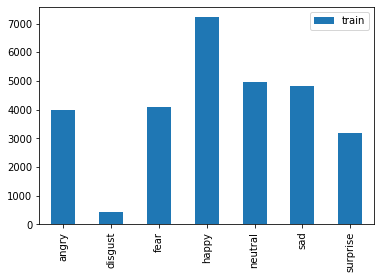

In [ ]:
train_count.transpose().plot(kind='bar')

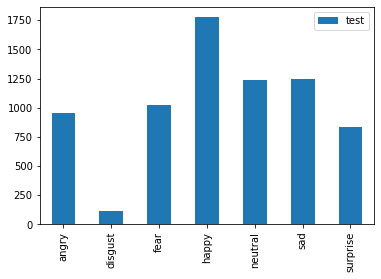

In [ ]:
test_count.transpose().plot(kind='bar')

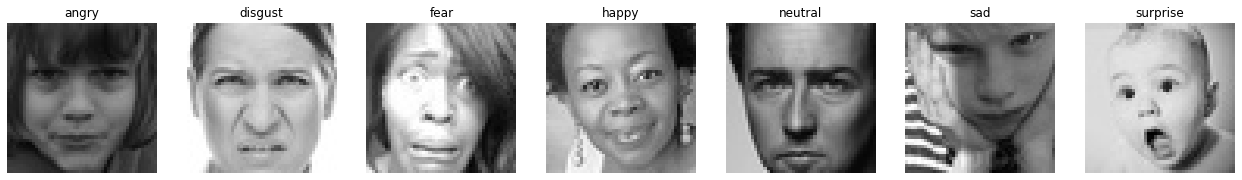

In [ ]:
plt.figure(figsize=(22,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    print()
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')
### size of training_set ==  28709
test_datagen = ImageDataGenerator(rescale=1./255.0)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
print(training_set.class_indices)
print(test_set.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=adam_v2.Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
model = get_model((row,col,1),classes)
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 22, 22, 256)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


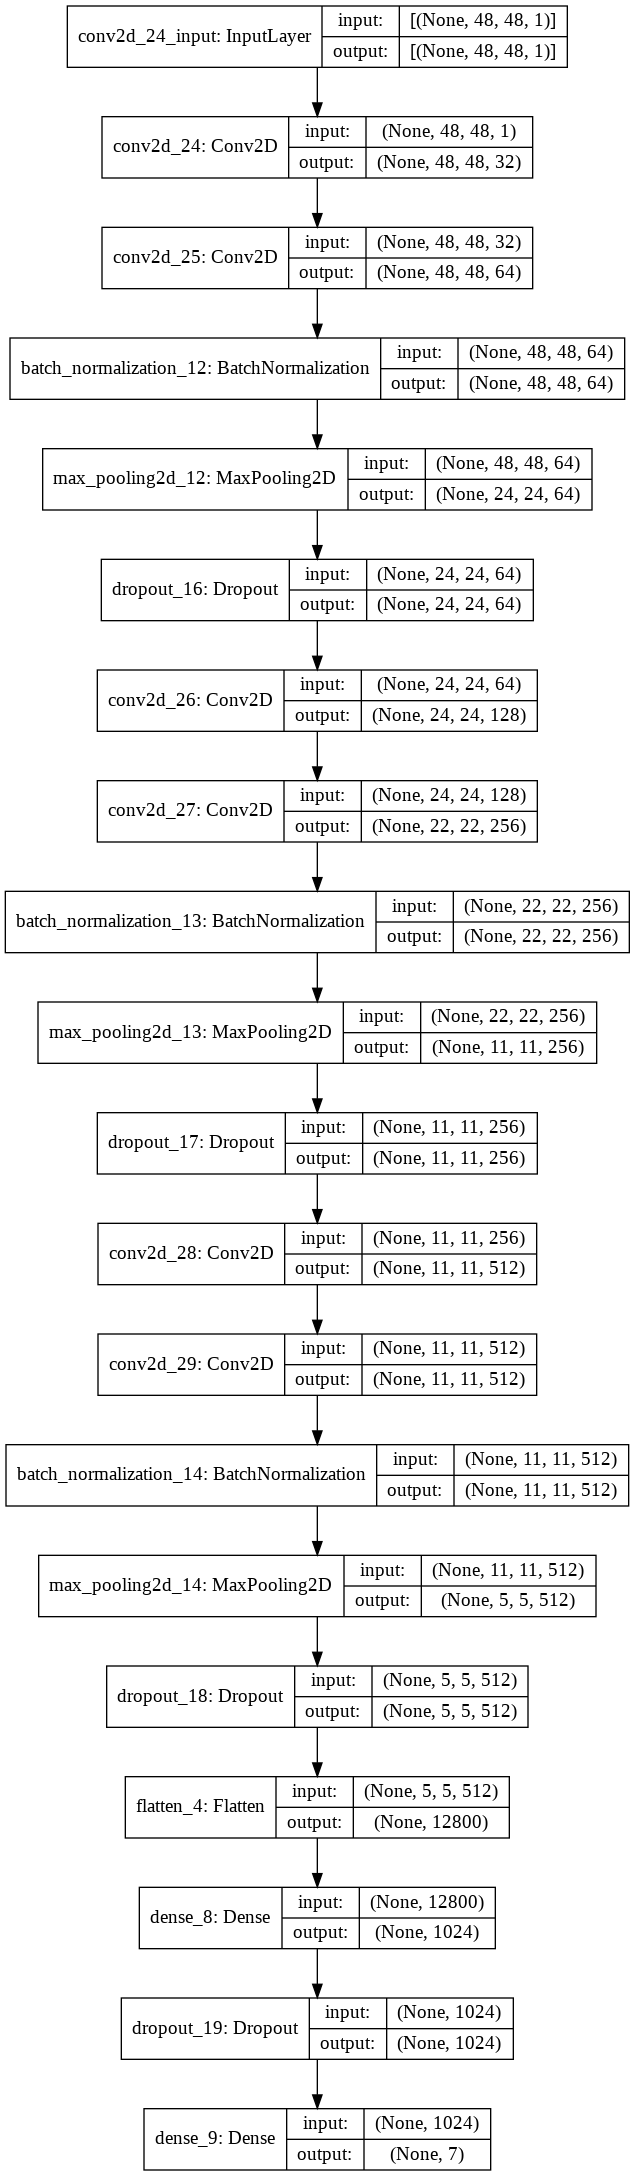

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
chk_path = 'model.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - 51s 112ms/step - loss: 13.2346 - accuracy: 0.2329 - val_loss: 15.6409 - val_accuracy: 0.0451

Epoch 00001: val_loss improved from inf to 15.64085, saving model to model.h5
Epoch 2/60
448/448 [==============================] - 50s 111ms/step - loss: 10.2183 - accuracy: 0.3064 - val_loss: 8.4569 - val_accuracy: 0.3651

Epoch 00002: val_loss improved from 15.64085 to 8.45692, saving model to model.h5
Epoch 3/60
448/448 [==============================] - 51s 114ms/step - loss: 7.7484 - accuracy: 0.3459 - val_loss: 6.1256 - val_accuracy: 0.4012

Epoch 00003: val_loss improved from 8.45692 to 6.12562, saving model to model.h5
Epoch 4/60
448/448 [==============================] - 50s 112ms/step - loss: 5.7540 - accuracy: 0.3742 - val_loss: 4.5031 - val_accuracy: 0.4371

Epoch 00004: val_loss improved from 6.12562 to 4.50313, saving model to model.h5
Epoch 5/60
448/448 [==============================] - 50s 112ms/step - loss: 4.2788 - accur

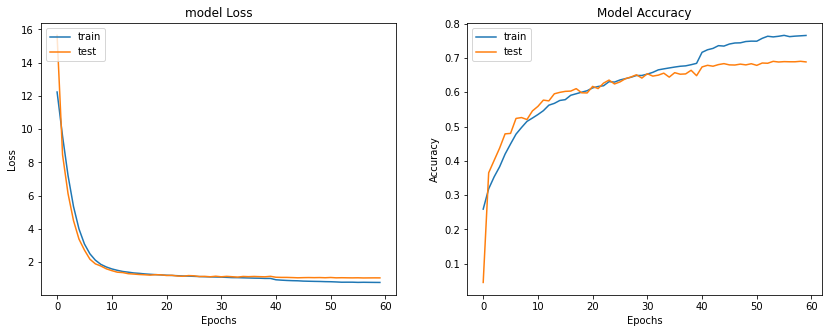

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = model.evaluate(training_set)
test_loss, test_accu = model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 8s 70ms/step - loss: 1.0590 - accuracy: 0.6884
final train accuracy = 82.33 , validation accuracy = 68.84


In [ ]:
model.save_weights('model_bestweight.h5')

Confusion Matrix
[[ 519   55  490  983  793  683  472]
 [  44    4   47  123   91   70   57]
 [ 516   60  538 1072  799  674  438]
 [ 930   97  908 1846 1378 1256  800]
 [ 622   71  576 1298  950  877  571]
 [ 587   60  604 1242  905  871  561]
 [ 411   28  396  826  612  525  373]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.15      0.13      0.14      4097
       happy       0.25      0.26      0.25      7215
     neutral       0.17      0.19      0.18      4965
         sad       0.18      0.18      0.18      4830
    surprise       0.11      0.12      0.12      3171

    accuracy                           0.18     28709
   macro avg       0.15      0.15      0.14     28709
weighted avg       0.18      0.18      0.18     28709



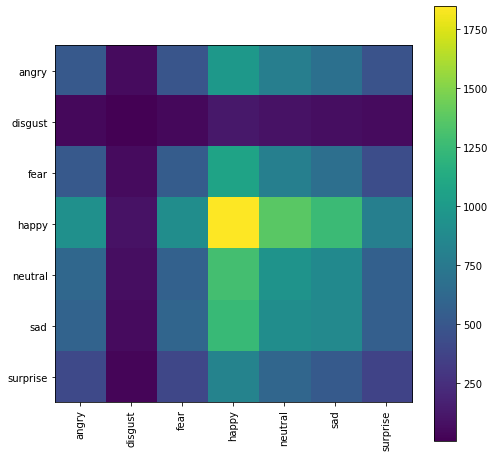

In [ ]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[130   8 104 228 184 192 112]
 [ 17   1  13  23  26  19  12]
 [130  13 112 270 205 181 113]
 [243  20 205 423 341 325 217]
 [178  15 166 307 241 195 131]
 [163  12 147 314 259 185 167]
 [103   8 102 219 156 145  98]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.14       958
     disgust       0.01      0.01      0.01       111
        fear       0.13      0.11      0.12      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.17      0.20      0.18      1233
         sad       0.15      0.15      0.15      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.16      0.17      0.16      7178



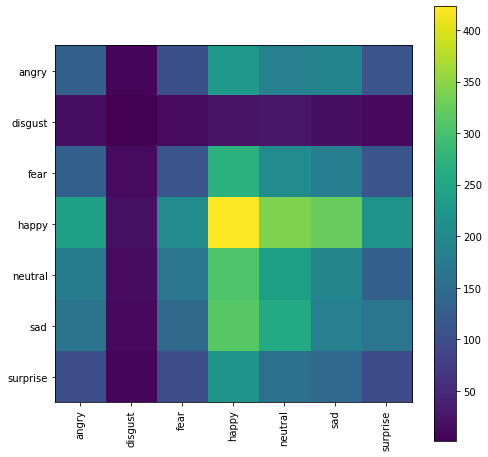

In [ ]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)